The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Transformed DataFrame with X:
         T2         Z        T1          Y        X1        X2        X3  \
0 -2.111262 -0.550313 -2.531198  -9.951743 -0.164488 -3.001065 -1.036825   
1  1.322403  0.928302  0.866724   6.496101  0.981079  2.377455  2.086539   
2  2.062027  1.016687  1.677992   9.939158  1.425783  4.017473  2.322252   
3  8.660278  1.436865  4.054484  40.417528  2.932685  5.357868  5.216129   
4 -0.552941 -0.386397 -1.083801  -2.722261 -1.728080 -1.586615 -0.267437   

          X4  
0  -4.596916  
1   7.548986  
2  10.292183  
3  11.845303  
4  -4.263555  


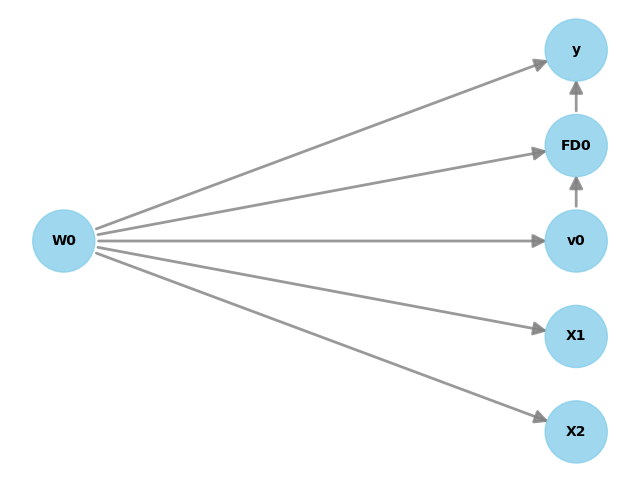

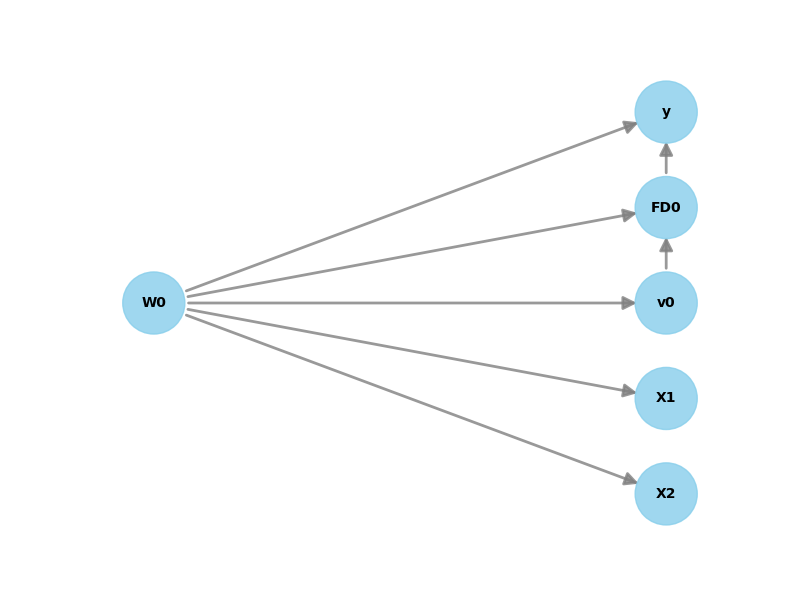

In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import logging

import networkx as nx
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import pickle
import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

data = dowhy.datasets.linear_dataset(BETA, num_common_causes=1, num_samples=10000,num_frontdoor_variables=1,
                                    num_instruments=0, num_effect_modifiers=0,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=0,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df = data['df']

# w0에 종속적인 X 변수를 추가합니다.
w0 = df['W0']
df['X1'] = 2 * w0 + np.random.normal(0, 1, size=len(df))
df['X2'] = 4 * w0 + np.random.normal(0, 1, size=len(df))
df['X3'] = 3 * w0 + np.random.normal(0, 1, size=len(df))
df['X4'] = 9 * w0 + np.random.normal(0, 1, size=len(df))
df = df.rename(columns={'FD0': 'T2', 'W0': 'Z', 'v0': 'T1', 'y': 'Y'})
data['df'] = df

print("Transformed DataFrame with X:")
print(df.head())

# 기존 그래프를 NetworkX 그래프로 변환합니다.
G = nx.DiGraph(nx.parse_gml(data['gml_graph']))

# w0 -> X 관계를 그래프에 추가합니다.
G.add_edge('W0', 'X1')
G.add_edge('W0', 'X2')

# 수정된 그래프를 GML 문자열로 변환합니다.
new_gml_graph = nx.generate_gml(G)
new_gml_graph_str = "\n".join(list(new_gml_graph))
data['gml_graph'] = new_gml_graph_str

# 새로운 그래프로 모델을 생성합니다.
model = CausalModel(
    data=data["df"],
    treatment='FD0',  # 분석하려는 관계의 원인 변수
    outcome='y',  # 분석하려는 관계의 결과 변수
    graph=data["gml_graph"]
)

model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

with open('synthetic_dowhy.pkl', 'wb') as f:
    pickle.dump(df, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Original DataFrame:
        FD0        W0        v0          y
0  0.372151  0.306364 -0.510429   1.726855
1  3.365241  0.738238 -0.129574   6.412706
2  1.298548 -0.837158  1.066943  -2.597376
3 -5.671034 -3.387040 -2.141145 -20.525877
4 -4.655736 -2.149534 -2.557249 -13.981175


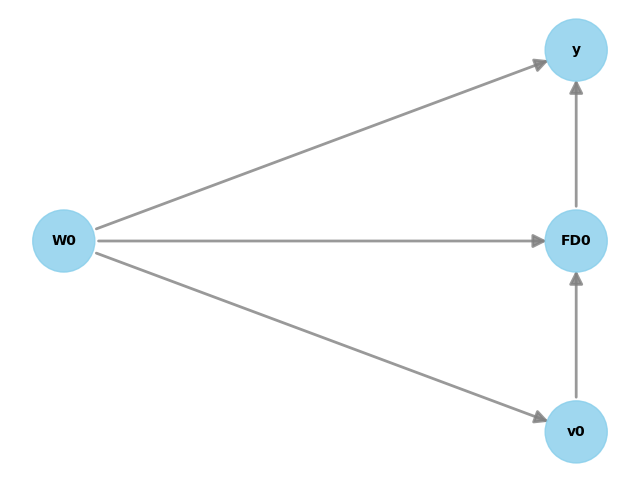

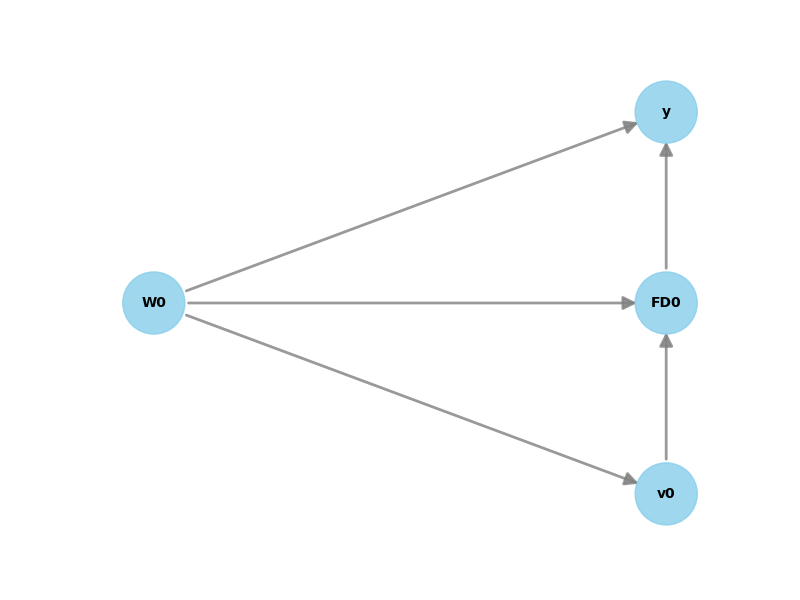

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import logging

import networkx as nx
import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

data = dowhy.datasets.linear_dataset(BETA, num_common_causes=1, num_samples=10000,num_frontdoor_variables=1,
                                    num_instruments=0, num_effect_modifiers=0,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=0,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df = data['df']
print("Original DataFrame:")
print(df.head())


# 새로운 그래프로 모델을 생성합니다.
model = CausalModel(
    data=data["df"],
    treatment='FD0',  # 분석하려는 관계의 원인 변수
    outcome='y',  # 분석하려는 관계의 결과 변수
    graph=data["gml_graph"]
)

model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
# 인과 효과를 식별합니다.
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# 인과 효과를 추정합니다.
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is ", estimate.value)

# 모델 검증
refute_results = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute_results)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
──────(E[y|W0])
d[FD₀]         
Estimand assumption 1, Unconfoundedness: If U→{FD0} and U→y then P(y|FD0,W0,U) = P(y|FD0,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal Estimate is  4.256847777987609
Refute: Use a Placebo Treatment
Estimated effect:4.256847777987609
New effect:0.0
p value:1.0



In [5]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

# DoWhy를 사용하여 데이터 생성
data = dowhy.datasets.linear_dataset(
    beta=BETA,
    num_common_causes=4,
    num_samples=10000,
    num_instruments=2,
    num_effect_modifiers=2,
    num_treatments=1,
    treatment_is_binary=False,
    num_discrete_common_causes=2,
    num_discrete_effect_modifiers=0,
    one_hot_encode=False
)

df = data['df']

# 기존 데이터셋을 출력
print(df.head())
print("True causal estimate is", data["ate"])

# 데이터셋 변형
# T1, T2를 Z와 Y와 연결
# 여기서는 X는 무시하고 T1과 T2로 대체
Z = df[['W0', 'W1', 'W2', 'W3']]
T1 = Z['W0'] + Z['W1'] + np.random.normal(0, 1, size=len(df))
T2 = T1 + Z['W2'] + np.random.normal(0, 1, size=len(df))
Y = BETA * T2 + Z['W3'] + np.random.normal(0, 1, size=len(df))

# 변형된 데이터프레임 생성
df_transformed = pd.DataFrame({
    'Z0': Z['W0'],
    'Z1': Z['W1'],
    'Z2': Z['W2'],
    'Z3': Z['W3'],
    'T1': T1,
    'T2': T2,
    'Y': Y
})

print(df_transformed.head())

# DoWhy를 사용하여 SCM 정의
model = CausalModel(
    data=df_transformed,
    treatment=['T1', 'T2'],
    outcome='Y',
    graph="digraph {Z0 -> T1; Z1 -> T1; Z2 -> T2; Z3 -> Y; T1 -> T2; T2 -> Y}"
)

# 모델의 그래프 시각화
model.view_model()

# DoWhy를 사용하여 인과 추론 수행
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is ", estimate.value)

# 모델 검증
refute_results = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute_results)


         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.343704  1.109438  1.0  0.726998 -0.727119 -0.631718  1  0  18.604604   
1  0.479997  0.759405  0.0  0.820843  0.053309  0.335354  3  2  26.426019   
2  1.076488  1.238342  0.0  0.113396 -0.543821 -0.311856  0  3   7.976311   
3 -1.160638  0.164934  1.0  0.623403  0.647430 -0.485036  0  2  23.788680   
4 -0.848556 -0.459125  0.0  0.043117 -0.453775  0.476357  2  1  10.736117   

            y  
0  187.148873  
1  302.460845  
2  102.130359  
3  217.195829  
4   99.824328  
True causal estimate is 10.43059997836694


TypeError: Object with dtype category cannot perform the numpy op add